In [5]:
import numpy as np
import wave
import matplotlib.pyplot as plt

In [2]:
def generate_noisy_audio(output_file, duration_seconds=10, noise_amplitude=0.5, pause_info=None):
    """
    Generate an audio file with noise and pauses.

    Parameters:
    - output_file (str): The path to the output audio file.
    - duration_seconds (int): Total duration of the audio file in seconds.
    - noise_amplitude (float): Amplitude of the noise. Value between 0 and 1.
    - pause_info (list of tuples): List of tuples specifying pauses.
                                  Each tuple is of the form (start_time, duration).
                                  Example: [(2, 1), (5, 2)] for a 1-second pause at 2 seconds and a 2-second pause at 5 seconds.
    """
    # Samplingrate und Anzahl der Samples pro Sekunde festlegen
    sample_rate = 44100
    num_samples = int(duration_seconds * sample_rate)

    # Zeitvektor erstellen
    t = np.linspace(0, duration_seconds, num_samples, endpoint=False)

    # Lautstärke des Rauschens festlegen
    noise = noise_amplitude * np.random.normal(size=num_samples)

    # Audio-Signal erstellen
    audio_signal = (noise * 32767).astype(np.int16)

    # Stille hinzufügen (Pausen)
    if pause_info:
        for pause_start, pause_duration in pause_info:
            pause_samples = int(pause_duration * sample_rate)
            start_index = int(pause_start * sample_rate)
            end_index = start_index + pause_samples
            audio_signal[start_index:end_index] = 0

    # WAV-Datei erstellen
    with wave.open(output_file, 'w') as wave_file:
        wave_file.setnchannels(1)  # Mono
        wave_file.setsampwidth(2)  # 16-bit
        wave_file.setframerate(sample_rate)
        wave_file.writeframes(audio_signal.tobytes())

# Beispielaufruf
generate_noisy_audio("noisy_audio_with_pauses.wav", duration_seconds=10, noise_amplitude=0.5, pause_info=[(2, 1), (5, 2)])

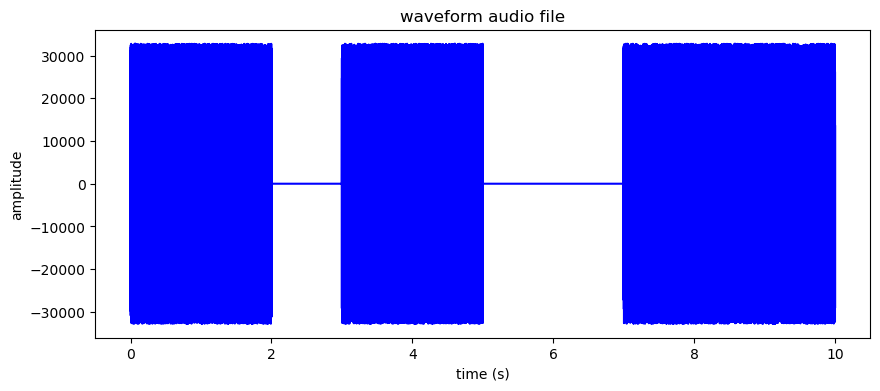

In [7]:
def plot_wav_volume(wav_file):
    # WAV-Datei einlesen
    with wave.open(wav_file, 'rb') as wave_file:
        # Die Anzahl der Frames (Samples) und die Samplerate erhalten
        num_frames = wave_file.getnframes()
        sample_rate = wave_file.getframerate()

        # Die gesamte Audiodatei als Numpy-Array lesen
        audio_signal = np.frombuffer(wave_file.readframes(num_frames), dtype=np.int16)

    # Zeitvektor erstellen
    t = np.linspace(0, len(audio_signal) / sample_rate, num=len(audio_signal))

    # Plot erstellen
    plt.figure(figsize=(10, 4))
    plt.plot(t, audio_signal, color='b')
    plt.title('waveform audio file')
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    plt.show()

# Beispielaufruf (ersetze "dein_audio.wav" durch den Pfad zu deiner WAV-Datei)
plot_wav_volume("noisy_audio_with_pauses.wav")

In [8]:
from pydub import AudioSegment
from pydub.silence import split_on_silence

def remove_silence(input_file, output_file, silence_threshold=-50):
    # Lade die Audio-Datei
    audio = AudioSegment.from_file(input_file)

    # Teile die Audio-Datei anhand der Stille
    non_silent_segments = split_on_silence(audio, silence_thresh=silence_threshold)

    # Füge die nicht stillen Segmente wieder zusammen
    output_audio = sum(non_silent_segments)

    # Speichere die Ausgabe in einer neuen Datei
    output_audio.export(output_file, format="wav")

# Beispielaufruf
remove_silence("noisy_audio_with_pauses.wav", "output_audio_without_silence.wav", silence_threshold=-50)

/home/dan/anaconda3/lib/python3.11/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


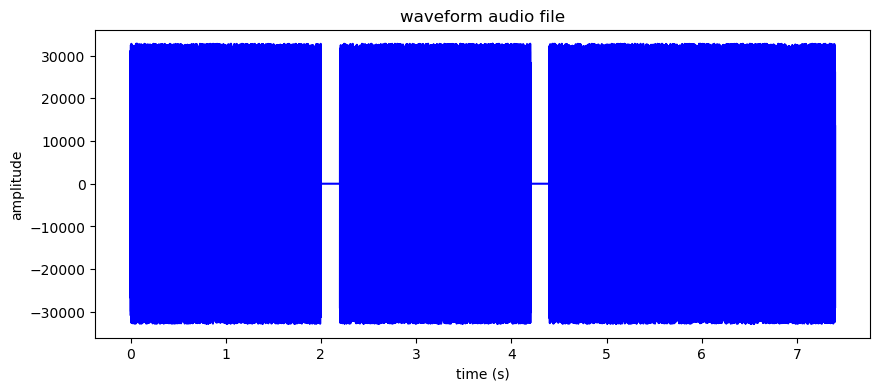

In [9]:
plot_wav_volume("output_audio_without_silence.wav")

In [14]:
from pydub import AudioSegment
from pydub.silence import detect_nonsilent

def remove_silence(input_file, output_file, silence_threshold=-50):
    # Lade die Audio-Datei
    audio = AudioSegment.from_file(input_file)

    # Finde die nicht stillen Stellen
    nonsilent_ranges = detect_nonsilent(audio, silence_thresh=silence_threshold)

    # Extrahiere die nicht stillen Stellen
    non_silent_audio = sum(audio[start:end] for (start, end) in nonsilent_ranges)

    # Speichere die Ausgabe in einer neuen Datei
    non_silent_audio.export(output_file, format="wav")

# Beispielaufruf
remove_silence("_003.wav", "_003_edit.wav", silence_threshold=-50)

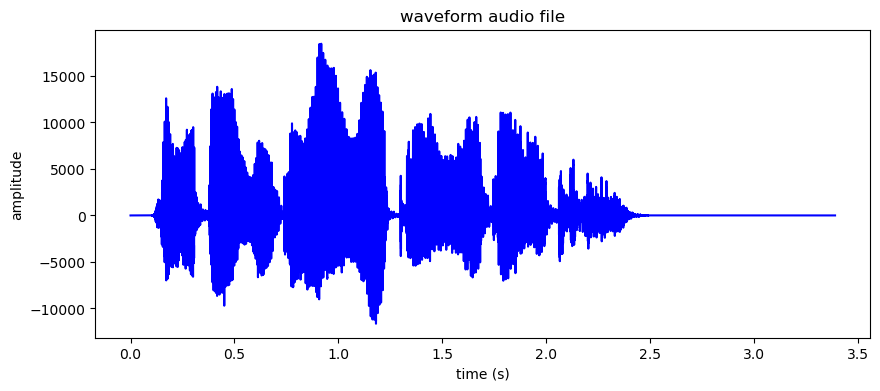

In [15]:
plot_wav_volume("_003.wav")

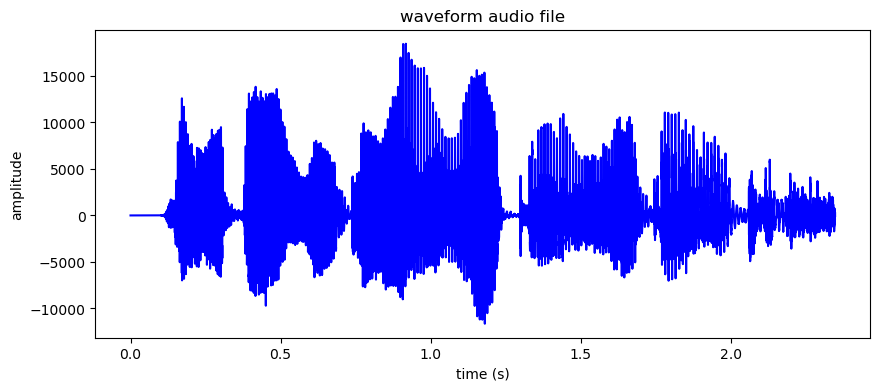

In [16]:
plot_wav_volume("_003_edit.wav")

In [12]:
import tkinter as tk
from tkinter import filedialog
from pydub import AudioSegment
from pydub.silence import detect_nonsilent

class AudioSilenceRemovalApp:
    def __init__(self, master):
        self.master = master
        self.master.title("Audio Silence Removal Tool")

        # UI-Elemente erstellen
        self.label = tk.Label(master, text="Choose an audio file:")
        self.label.pack()

        self.choose_file_button = tk.Button(master, text="Choose File", command=self.choose_file)
        self.choose_file_button.pack()

        self.threshold_label = tk.Label(master, text="Silence Threshold (dB):")
        self.threshold_label.pack()

        self.threshold_entry = tk.Entry(master)
        self.threshold_entry.pack()

        self.remove_silence_button = tk.Button(master, text="Remove Silence", command=self.remove_silence)
        self.remove_silence_button.pack()

    def choose_file(self):
        file_path = filedialog.askopenfilename(filetypes=[("Audio Files", "*.wav;*.mp3")])
        if file_path:
            self.file_path = file_path
            self.label.config(text=f"Selected file: {file_path}")

    def remove_silence(self):
        if hasattr(self, 'file_path'):
            threshold = float(self.threshold_entry.get()) if self.threshold_entry.get() else -50

            # Lade die Audio-Datei
            audio = AudioSegment.from_file(self.file_path)

            # Finde die nicht stillen Stellen
            nonsilent_ranges = detect_nonsilent(audio, silence_thresh=threshold)

            # Extrahiere die nicht stillen Stellen
            non_silent_audio = sum(audio[start:end] for (start, end) in nonsilent_ranges)

            # Speichere die Ausgabe in einer neuen Datei
            output_path = filedialog.asksaveasfilename(defaultextension=".wav", filetypes=[("WAV Files", "*.wav")])
            if output_path:
                non_silent_audio.export(output_path, format="wav")
                tk.messagebox.showinfo("Success", f"Silence removed. Saved to {output_path}")
        else:
            tk.messagebox.showwarning("Warning", "Please choose an audio file first.")

def main():
    root = tk.Tk()
    app = AudioSilenceRemovalApp(root)
    root.mainloop()

if __name__ == "__main__":
    main()
